In [29]:
'''Important Libraries and Modules that would be used throughout the task are imported'''
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import concatenate
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import Conv2D
from keras.layers import MaxPooling1D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.layers import LeakyReLU
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import Multiply
from keras.layers import GlobalAveragePooling1D
from keras.layers import AveragePooling1D
from keras.layers import TimeDistributed
from keras.layers import Reshape
import tensorflow as tf
from keras.engine.topology import Layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from keras.models import load_model
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Loading of Data in Pandas DataFrame from CSV file
#Other Features were removed from the CSV as they are not used in the tasks 
data=pd.read_csv("/content/drive/MyDrive/IIIT_MIDAS/flipkart_com-ecommerce_sample.csv", encoding= 'unicode_escape')
print(len(data))
data.head()

20000


,product_category_tree,description,brand
0,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Alisha
1,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...,FabHomeDecor
2,"[""Footwear >> Women's Footwear >> Ballerinas >...",Key Features of AW Bellies Sandals Wedges Heel...,AW
3,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Alisha
4,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Specifications of Sicons All Purpose Arnica Do...,Sicons


In [4]:
data.description[0]

"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentle Machine Wash in Lukewarm Water, Do Not Bleach Additional Details Style Code ALTHT_3P_21 In the Box 3 shorts"

In [5]:
#Text Preprocessing
category=[]
description=[]
for i in range(len(data)):
  if type(data['description'][i]) == str :
    category.append(data["product_category_tree"][i].split('>>')[0][2:-1]) #Primary Category is being extracted from the product category tree
    des = re.sub('[^a-zA-Z]', ' ', data['description'][i])
    des = re.sub('[/(){}\[\]\|@,.;_]', ' ', des) #Removing the symbols that are not useful in classification task
    des = des.lower() #Converting the text into lowercase 
    description.append(des) 

data = pd.DataFrame()
data["category"]=category
data["description"]=description
data.head()    


,category,description
0,Clothing,key features of alisha solid women s cycling s...
1,Furniture,fabhomedecor fabric double sofa bed finish co...
2,Footwear,key features of aw bellies sandals wedges heel...
3,Clothing,key features of alisha solid women s cycling s...
4,Pet Supplies,specifications of sicons all purpose arnica do...


Total No. of Categories : 266


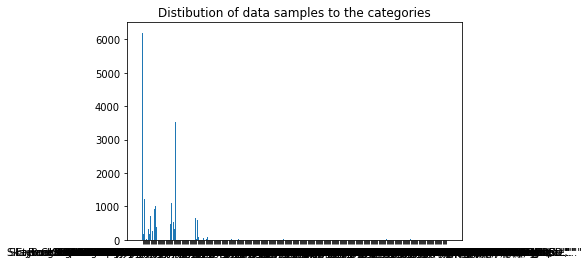

In [6]:
# Distibution of data samples to the categories
category_counts= Counter(category)
print(f"Total No. of Categories :",len(category_counts.keys()))
plt.bar(category_counts.keys(),category_counts.values() )
plt.title(label='Distibution of data samples to the categories')
plt.show() 

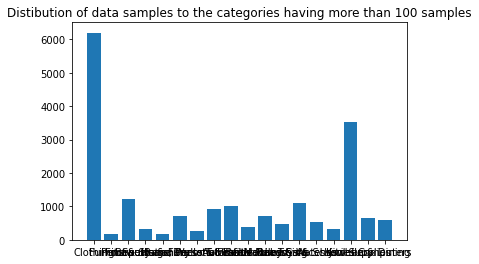

In [7]:
#only keeping the categories with more than 100 samples
new_dict={}
for key, value in category_counts.items():
  if value>100:
    new_dict[key]=value
plt.bar(new_dict.keys(),new_dict.values())
plt.title(label='Distibution of data samples to the categories having more than 100 samples')
plt.show() 

In [8]:
new_dict

{'Automotive': 1012,
 'Baby Care': 483,
 'Bags, Wallets & Belts': 265,
 'Beauty and Personal Care': 710,
 'Clothing': 6197,
 'Computers': 578,
 'Footwear': 1227,
 'Furniture': 180,
 'Home Decor & Festive Needs': 929,
 'Home Furnishing': 699,
 'Jewellery': 3531,
 'Kitchen & Dining': 647,
 'Mobiles & Accessories': 1099,
 'Pens & Stationery': 313,
 'Sports & Fitness': 166,
 'Tools & Hardware': 391,
 'Toys & School Supplies': 330,
 'Watches': 530}

In [9]:
#Storing the description and category having more than 100 instances in dataframe
new_description=[]
new_category=[]
for i in range(len(description)):
  if category[i] in new_dict.keys():
    new_description.append(description[i])
    new_category.append(category[i])
    
new_df=pd.DataFrame()
new_df["description"]=new_description
new_df["category"]=new_category
new_df.head()

,description,category
0,key features of alisha solid women s cycling s...,Clothing
1,fabhomedecor fabric double sofa bed finish co...,Furniture
2,key features of aw bellies sandals wedges heel...,Footwear
3,key features of alisha solid women s cycling s...,Clothing
4,key features of alisha solid women s cycling s...,Clothing


In [10]:
#Encoding the textual label to the integer labels
lab_enc = preprocessing.LabelEncoder()
lab_enc.fit(new_df.category)
new_df['categorical_label'] = lab_enc.transform(new_df.category)
new_df.head()

,description,category,categorical_label
0,key features of alisha solid women s cycling s...,Clothing,4
1,fabhomedecor fabric double sofa bed finish co...,Furniture,7
2,key features of aw bellies sandals wedges heel...,Footwear,6
3,key features of alisha solid women s cycling s...,Clothing,4
4,key features of alisha solid women s cycling s...,Clothing,4


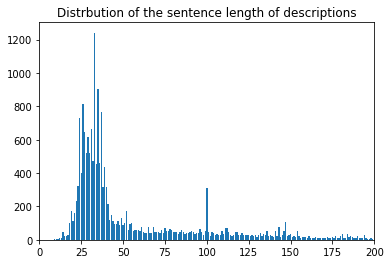

In [11]:
#analysing the sentence length of the description
df=new_df["description"]
length=[]
for i in range(len(df)) :
  if type(df[i])==str:
    length.append(len(nltk.word_tokenize(df[i])))
c= Counter(length)
plt.bar(c.keys(),c.values())
plt.xlim(0,200)
plt.title(label='Distrbution of the sentence length of descriptions')
plt.show() 

In [12]:
#Splitting the dataset into training, testing and validation data
X_train, X_test, y_train, y_test = train_test_split(new_df["description"], new_df["categorical_label"], test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [13]:
#Fitting the tokenizer on the trainig dataset 
sent_length=128
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
voc_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", voc_size)


Vocabulary Size: 16399


In [14]:
#Converting the Description in the training data to the tokens 
sequences = tokenizer.texts_to_sequences(X_train)
embedded_docs=pad_sequences(sequences,padding='post',maxlen=sent_length)
X_train=np.array(embedded_docs)

In [15]:
#Converting the Description in the testing data to the tokens 
sequences = tokenizer.texts_to_sequences(X_test)
embedded_docs=pad_sequences(sequences,padding='post',maxlen=sent_length)
X_test=np.array(embedded_docs)    

In [16]:
#Converting the Description in the validation data to the tokens 
sequences = tokenizer.texts_to_sequences(X_val)
embedded_docs=pad_sequences(sequences,padding='post',maxlen=sent_length)
X_val=np.array(embedded_docs)  

In [ ]:
#Buiding the LSTM Model for Category Classification
embedding_vector_features=100
input=Input(shape=(sent_length,), name='inputs')
x=Embedding(voc_size,embedding_vector_features,input_length=sent_length)(input)
x=Bidirectional(LSTM(64))(x)
x=BatchNormalization()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(64,activation='relu')(x)
x=Dense(18,activation='softmax',name='truth_')(x)
model1=Model(inputs=input, outputs=x, name='LSTM')
model1.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model1.summary()
#plot_model(model1,show_layer_names=True,show_shapes=True)

LSTM_save = ModelCheckpoint('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'LSTM.hdf5', save_best_only=True, monitor='val_loss', mode='min')

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 128, 100)          1639900   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               84480     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                16448  

In [ ]:
#Training the LSTM model
model1.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), callbacks=LSTM_save, batch_size=64, epochs=10)

Epoch 1/10
211/211 [==============================] - 10s 35ms/step - loss: 1.3085 - accuracy: 0.6375 - val_loss: 1.1632 - val_accuracy: 0.8912
Epoch 2/10
211/211 [==============================] - 7s 31ms/step - loss: 0.1254 - accuracy: 0.9639 - val_loss: 0.2881 - val_accuracy: 0.9368
Epoch 3/10
211/211 [==============================] - 7s 31ms/step - loss: 0.0436 - accuracy: 0.9877 - val_loss: 0.1835 - val_accuracy: 0.9523
Epoch 4/10
211/211 [==============================] - 6s 30ms/step - loss: 0.0215 - accuracy: 0.9931 - val_loss: 0.3673 - val_accuracy: 0.9340
Epoch 5/10
211/211 [==============================] - 6s 30ms/step - loss: 0.0208 - accuracy: 0.9935 - val_loss: 0.2603 - val_accuracy: 0.9496
Epoch 6/10
211/211 [==============================] - 6s 30ms/step - loss: 0.0179 - accuracy: 0.9942 - val_loss: 0.2790 - val_accuracy: 0.9478
Epoch 7/10
211/211 [==============================] - 6s 30ms/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.2589 - val_accuracy: 0.956

In [ ]:
#Testing the Model on Text Dataset
print("FOR LSTM MODEL")
saved_model=load_model('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'LSTM.hdf5')
y_prob = saved_model.predict(X_test)
y_pred = np.argmax(y_prob,axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

FOR LSTM MODEL
Accuracy: 0.959558
Precision: 0.925966
Recall: 0.915875
F1 score: 0.917844


Text(0.5, 1.0, 'CONFUSION MATRIX')

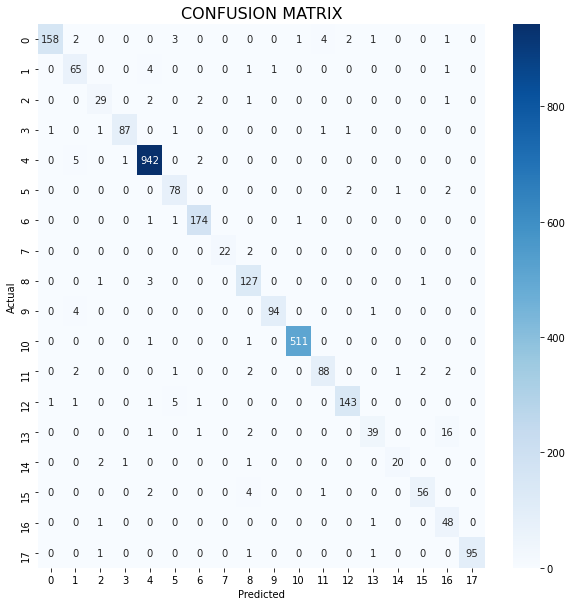

In [ ]:
#Plotting the Confusion Matrix 
conf_mat = confusion_matrix(lab_enc.inverse_transform(y_test), lab_enc.inverse_transform(y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX", size=16)

In [ ]:
#Building the CNN model
input=Input(shape=(sent_length,))
x=Embedding(voc_size,embedding_vector_features,input_length=sent_length)(input)
x=Conv1D(128, 5, padding='same', activation='relu' )(x)
x=BatchNormalization()(x)
x=MaxPooling1D(pool_size=2,strides=None)(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(64,activation='relu')(x)
x=Dense(18,activation='softmax')(x)
model2=Model(inputs=input, outputs=x, name='CNN')
model2.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model2.summary()
#plot_model(model3,show_layer_names=True,show_shapes=True)

CNN_save = ModelCheckpoint('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'CNN.hdf5', save_best_only=True, monitor='val_loss', mode='min')


Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 128, 100)          1639900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 128)          64128     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128)          512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               2097408 

In [ ]:
#Training the CNN model
model2.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), callbacks=CNN_save, batch_size=64, epochs =10)

Epoch 1/10
211/211 [==============================] - 5s 23ms/step - loss: 1.1740 - accuracy: 0.6731 - val_loss: 1.6280 - val_accuracy: 0.9140
Epoch 2/10
211/211 [==============================] - 4s 20ms/step - loss: 0.1027 - accuracy: 0.9710 - val_loss: 0.4311 - val_accuracy: 0.9513
Epoch 3/10
211/211 [==============================] - 4s 20ms/step - loss: 0.0349 - accuracy: 0.9897 - val_loss: 0.1688 - val_accuracy: 0.9575
Epoch 4/10
211/211 [==============================] - 4s 21ms/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.1946 - val_accuracy: 0.9610
Epoch 5/10
211/211 [==============================] - 4s 21ms/step - loss: 0.0088 - accuracy: 0.9968 - val_loss: 0.2046 - val_accuracy: 0.9613
Epoch 6/10
211/211 [==============================] - 4s 21ms/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.2564 - val_accuracy: 0.9596
Epoch 7/10
211/211 [==============================] - 4s 20ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.2208 - val_accuracy: 0.9561

In [ ]:
#Testing the CNN model on test dataset
print("FOR CNN MODEL")
saved_model=load_model('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'CNN.hdf5')
y_prob = saved_model.predict(X_test)
y_pred = np.argmax(y_prob,axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

FOR CNN MODEL
Accuracy: 0.953681
Precision: 0.900097
Recall: 0.883387
F1 score: 0.890072


Text(0.5, 1.0, 'CONFUSION MATRIX')

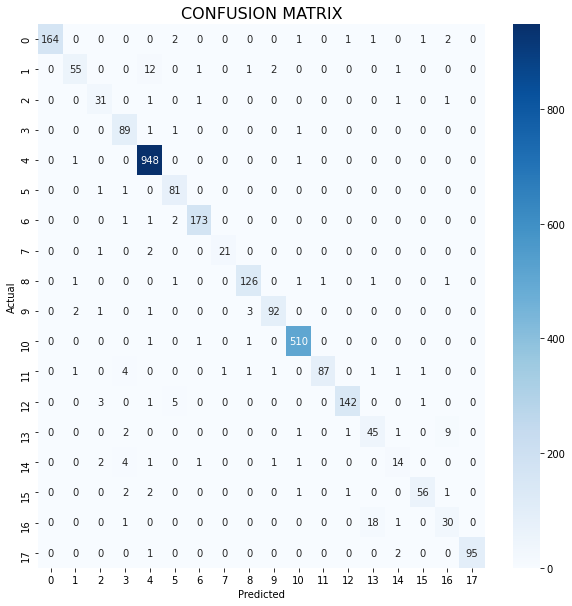

In [ ]:
#Plotting the Confusion Matrix
conf_mat = confusion_matrix(lab_enc.inverse_transform(y_test), lab_enc.inverse_transform(y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX", size=16)

In [ ]:
#Building the C_LSTM model
input=Input(shape=(sent_length,))
x=Embedding(voc_size,embedding_vector_features,input_length=sent_length)(input)
x=Conv1D(128, 5, padding='same', activation='relu' )(x)
x=MaxPooling1D(pool_size=2,strides=None)(x)
x=Bidirectional(LSTM(64))(x)
x=BatchNormalization()(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(64,activation='relu')(x)
x=Dense(18,activation='sigmoid',)(x)
model3=Model(inputs=input, outputs=x, name='C-LSTM')
model3.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model3.summary()
#plot_model(model5,show_layer_names=True,show_shapes=True)

CNN_LSTM_save = ModelCheckpoint('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'CNN_LSTM.hdf5', save_best_only=True, monitor='val_loss', mode='min')


Model: "C-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 128, 100)          1639900   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 64, 128)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               98816     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0    

In [ ]:
#training the C-LSTM model
model3.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), callbacks=CNN_LSTM_save, batch_size=64, epochs =10)

Epoch 1/10
211/211 [==============================] - 10s 34ms/step - loss: 1.2079 - accuracy: 0.6662 - val_loss: 1.0287 - val_accuracy: 0.9326
Epoch 2/10
211/211 [==============================] - 6s 30ms/step - loss: 0.1039 - accuracy: 0.9711 - val_loss: 0.2161 - val_accuracy: 0.9551
Epoch 3/10
211/211 [==============================] - 6s 30ms/step - loss: 0.0383 - accuracy: 0.9890 - val_loss: 0.1922 - val_accuracy: 0.9606
Epoch 4/10
211/211 [==============================] - 6s 30ms/step - loss: 0.0300 - accuracy: 0.9925 - val_loss: 0.2159 - val_accuracy: 0.9582
Epoch 5/10
211/211 [==============================] - 6s 29ms/step - loss: 0.0147 - accuracy: 0.9961 - val_loss: 0.2223 - val_accuracy: 0.9585
Epoch 6/10
211/211 [==============================] - 6s 29ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.2198 - val_accuracy: 0.9630
Epoch 7/10
211/211 [==============================] - 6s 29ms/step - loss: 0.0115 - accuracy: 0.9972 - val_loss: 0.2538 - val_accuracy: 0.958

In [ ]:
#Testing the C-LSTM model on test dataset
print("FOR C-LSTM MODEL")
saved_model=load_model('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'CNN_LSTM.hdf5')
y_prob = saved_model.predict(X_test)
y_pred = np.argmax(y_prob,axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

FOR C-LSTM MODEL
Accuracy: 0.960595
Precision: 0.924139
Recall: 0.905045
F1 score: 0.912104


Text(0.5, 1.0, 'CONFUSION MATRIX - C_LSTM MODEL')

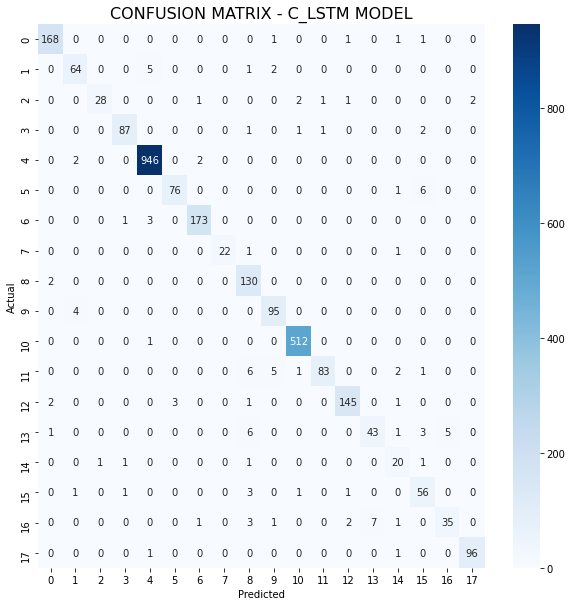

In [ ]:
#Plotting the Confusion Matrix
conf_mat = confusion_matrix(lab_enc.inverse_transform(y_test), lab_enc.inverse_transform(y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - C_LSTM MODEL", size=16)

In [30]:
#Defining a Convblock consisting of two Convolutional layers along with activation and BatchNormalization. A residual Convolutional Layer
#has also been added to maintain the flow of gradients while backpropogating. 
class ConvBlock(Layer):

    def __init__(self, n_filter, **kwargs):
        self.output_dim = n_filter
        self.n_filters = n_filter
        super(ConvBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.conv1 = Conv1D(self.n_filters, 3, padding='same',activation='relu'  )
        self.bn1 = BatchNormalization()
        self.conv2 = Conv1D(self.n_filters, 3, padding='same', activation='relu' )
        self.bn2 = BatchNormalization()
        self.conv3 = Conv1D(self.n_filters, 1, padding='same', activation='relu' )
        self.bn3 = BatchNormalization()
        super(ConvBlock, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        x = self.conv1(x)
        x=self.bn1(x) 
        x=self.conv2(x)
        x=self.bn2(x)
        y=self.conv3(x)
        y=self.bn3(y)
        x=x+y
        return x

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim)

In [41]:
#defining a function that would implement the VDCNN of varying length and will provide the Accuracy, Precision, Recall and F1 score
#for each case
def evaluate_VDCNN(X_train,y_train,X_test,y_test,X_val,y_val):
  n_filters=[64,128,256,256,512,512,512]
  metric=[]
  for i in range(1,7):

    input=Input(shape=(128,))
    x=Embedding(voc_size,100,input_length=128)(input)
    x=Conv1D(16, 3, padding='same', activation='relu' )(x)
    x=MaxPooling1D(pool_size=2,strides=None)(x)
    for j in range(i):
      x=ConvBlock(n_filters[j])(x)
      x=MaxPooling1D(pool_size=2,strides=None)(x)  
    x=Flatten()(x)
    x=Dropout(0.4)(x)
    x=Dense(256,activation='relu' )(x)
    x=Dense(18,activation='softmax' )(x)
    model = Model(inputs=input, outputs=x)
    model.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    model.summary()
    #plot_model(model5,show_layer_names=True,show_shapes=True)
    #VDCNN_save = ModelCheckpoint('/content/drive/MyDrive/IIIT_MIDAS/saved_models/VDCNN'+str(i)+'.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    model.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), batch_size=64, epochs =20)
    #saved_model=load_model('/content/drive/MyDrive/IIIT_MIDAS/saved_models/VDCNN'+str(i)+'.hdf5')
    y_prob = model.predict(X_test)
    y_pred = np.argmax(y_prob,axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    #print('Accuracy: %f' % accuracy)
    precision = precision_score(y_test, y_pred, average='macro')
    #print('Precision: %f' % precision)
    recall = recall_score(y_test, y_pred,average='macro')
    #print('Recall: %f' % recall)
    f1 = f1_score(y_test, y_pred,average='macro')
    #print('F1 score: %f' % f1)
    metric.append([accuracy,precision,recall,f1])
  return metric  


In [ ]:
result=evaluate_VDCNN(X_train,y_train,X_test,y_test,X_val,y_val)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 128, 100)          1639900   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 128, 16)           4816      
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 64, 16)            0         
_________________________________________________________________
conv_block_31 (ConvBlock)    (None, 64, 64)            20416     
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 32, 64)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 2048)              0  

In [44]:
result

[[0.9502246802627031,
  0.8824368592691857,
  0.889087564172298,
  0.8832671935838667],
 [0.9526443138610439,
  0.8915105109528407,
  0.8942890004428179,
  0.8876946297740458],
 [0.9554096094020048,
  0.8973856746431146,
  0.9021078718520822,
  0.8963498622215419],
 [0.9481507086069824,
  0.8984841643355254,
  0.884314298557449,
  0.8891755577168404],
 [0.9433114414103008,
  0.8635538619435458,
  0.8642972853102692,
  0.8561424505741213],
 [0.932250259246457,
  0.8664070034871815,
  0.8522422356399315,
  0.851639172406492]]

In [21]:
#Defining the Multi CNN model with 3 CNN'S of filter size 3, 5, 7 
embedding_vector_features=100
input=Input(shape=(sent_length,))
embedd=Embedding(voc_size,embedding_vector_features,input_length=sent_length)(input)
x1=Conv1D(128, 3, padding='same', activation='relu' )(embedd)
x1=MaxPooling1D(pool_size=2,strides=None)(x1)
x1=Flatten()(x1)
x2=Conv1D(128, 5, padding='same', activation='relu' )(embedd)
x2=MaxPooling1D(pool_size=2,strides=None)(x2)
x2=Flatten()(x2)
x3=Conv1D(128, 7, padding='same', activation='relu' )(embedd)
x3=MaxPooling1D(pool_size=2,strides=None)(x3)
x3=Flatten()(x3)
x = concatenate([x1,x2,x3])
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
x=Dense(64,activation='relu')(x)
x=Dense(18,activation='softmax')(x)
model5=Model(inputs=input, outputs=x,name='Multi_CNN')
model5.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model5.summary()
#plot_model(model5,show_layer_names=True,show_shapes=True,to_file='multichannel.png')

Multi_CNN_save = ModelCheckpoint('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'Multi_CNN.hdf5', save_best_only=True, monitor='val_loss', mode='min')


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 100)     1639900     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 128, 128)     38528       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 128, 128)     64128       embedding_1[0][0]                
____________________________________________________________________________________________

In [22]:
#training the Multi-CNN model
model5.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), callbacks=Multi_CNN_save, batch_size=64, epochs=10)

Epoch 1/10
211/211 [==============================] - 10s 44ms/step - loss: 1.4090 - accuracy: 0.5806 - val_loss: 0.2779 - val_accuracy: 0.9274
Epoch 2/10
211/211 [==============================] - 9s 43ms/step - loss: 0.1823 - accuracy: 0.9459 - val_loss: 0.2013 - val_accuracy: 0.9530
Epoch 3/10
211/211 [==============================] - 9s 40ms/step - loss: 0.0611 - accuracy: 0.9793 - val_loss: 0.2280 - val_accuracy: 0.9537
Epoch 4/10
211/211 [==============================] - 8s 38ms/step - loss: 0.0370 - accuracy: 0.9889 - val_loss: 0.2662 - val_accuracy: 0.9554
Epoch 5/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0177 - accuracy: 0.9940 - val_loss: 0.2372 - val_accuracy: 0.9596
Epoch 6/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.2646 - val_accuracy: 0.9565
Epoch 7/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0172 - accuracy: 0.9937 - val_loss: 0.2358 - val_accuracy: 0.958

In [24]:
#Testing the MULTICNN model on test dataset
print("FOR MULTICNN MODEL")
saved_model=load_model('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'Multi_CNN.hdf5')
y_prob = saved_model.predict(X_test)
y_pred = np.argmax(y_prob,axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

FOR MULTICNN MODEL
Accuracy: 0.967508
Precision: 0.928093
Recall: 0.922591
F1 score: 0.924243


Text(0.5, 1.0, 'CONFUSION MATRIX - MULTICNN MODEL')

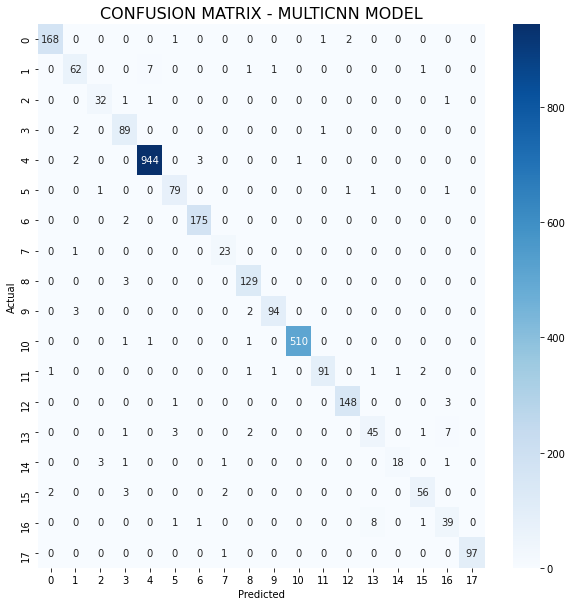

In [25]:
#Plotting the Confusion Matrix
conf_mat = confusion_matrix(lab_enc.inverse_transform(y_test), lab_enc.inverse_transform(y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - MULTICNN MODEL", size=16)